# Genre Predictor by Movie Poster
An excercise for the AI Couse

In [10]:
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from keras.preprocessing import image
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, roc_curve, classification_report
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Preparation

In [2]:
# Load the CSV file with image file paths and corresponding genres
csv_path = 'data/Multi_Label_dataset/train.csv'
df = pd.read_csv(csv_path)

# Define paths to the directory containing movie posters
image_dir = 'data/Multi_Label_dataset/Images/'

# Join the directory path with the image filenames
df['image_path'] = df['Id'].apply(lambda x: image_dir + x + '.jpg')

df['genre_array'] = df['Genre'].apply(lambda x: literal_eval(x))

df['first_genre'] = df['Genre'].apply(
    lambda x:
        x.split(',')[0]
        .replace('[', '')
        .replace('\'', '')
        .replace(']', ''))
# Display a few rows to check the data
#print(df.head())

all_genres = df.columns[2:-3]

In [3]:
print('---- basic structure of the data ----')
df.head(5)

---- basic structure of the data ----


,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,image_path,genre_array,first_genre
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086425.jpg,"[Comedy, Drama]",Comedy
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0085549.jpg,"[Drama, Romance, Music]",Drama
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086465.jpg,[Comedy],Comedy
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,data/Multi_Label_dataset/Images/tt0086567.jpg,"[Sci-Fi, Thriller]",Sci-Fi
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,data/Multi_Label_dataset/Images/tt0086034.jpg,"[Action, Adventure, Thriller]",Action


In [4]:
df.dtypes

Id             object
Genre          object
Action          int64
Adventure       int64
Animation       int64
Biography       int64
Comedy          int64
Crime           int64
Documentary     int64
Drama           int64
Family          int64
Fantasy         int64
History         int64
Horror          int64
Music           int64
Musical         int64
Mystery         int64
N/A             int64
News            int64
Reality-TV      int64
Romance         int64
Sci-Fi          int64
Short           int64
Sport           int64
Thriller        int64
War             int64
Western         int64
image_path     object
genre_array    object
first_genre    object
dtype: object

---- Genre Distribution with multi genre possibility  ----


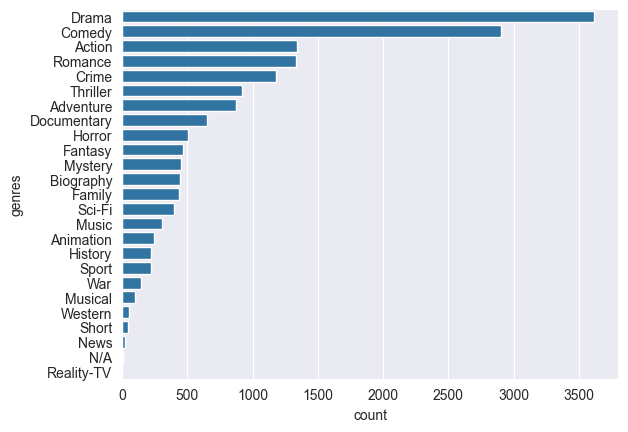

In [5]:
print('---- Genre Distribution with multi genre possibility  ----')

def print_genre_occurence(dataframe):
    genre_count = [len(dataframe[df[genre] == 1]) for genre in all_genres]
    genre_count_df = pd.DataFrame({
        'genres': all_genres,
        'count': genre_count
    })
    genre_count_df = genre_count_df.sort_values(by='count', ascending=False)
    sns.barplot(orient='horizontal', x='count', y='genres', data=genre_count_df)

print_genre_occurence(df)


,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Short,Sport,Thriller,War,Western,image_path,genre_array,first_genre,genres_to_predict
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,data/Multi_Label_dataset/Images/tt0086567.jpg,"[Sci-Fi, Thriller]",Sci-Fi,[Sci-Fi]
10,tt0086393,"['Action', 'Comedy', 'Sci-Fi']",1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086393.jpg,"[Action, Comedy, Sci-Fi]",Action,[Sci-Fi]
13,tt0085750,['Horror'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0085750.jpg,[Horror],Horror,[Horror]
16,tt0086312,"['Biography', 'Drama', 'History']",0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086312.jpg,"[Biography, Drama, History]",Biography,[Biography]
17,tt0086154,"['Crime', 'Horror', 'Mystery']",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,data/Multi_Label_dataset/Images/tt0086154.jpg,"[Crime, Horror, Mystery]",Crime,[Horror]


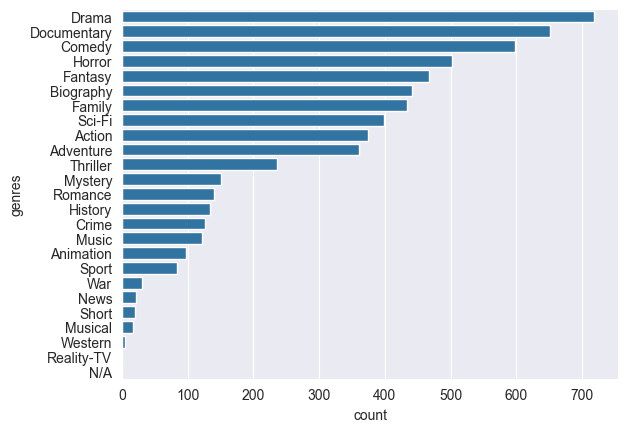

In [6]:
genres_to_predict = ['Documentary', 'Horror', 'Fantasy', 'Biography', 'Family', 'Sci-Fi']
df = df[
    (df['Documentary'] == 1)
    | (df['Horror'] == 1)
    | (df['Fantasy'] == 1)
    | (df['Biography'] == 1)
    | (df['Family'] == 1)
    | (df['Sci-Fi'] == 1)
]

df['genres_to_predict'] = df['genre_array'].apply(
    lambda x: [genre for genre in x if genre in genres_to_predict]
)

# TODO Make sure dataset is balanced

print_genre_occurence(df)
df.head(5)

In [7]:
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
#
# num_classes = len(genres_to_predict)
#
# # Create a data generator with data augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     validation_split=0.15,
#     horizontal_flip=False
# )
#
# # Create a data generator without data augmentation for testing
# test_datagen = ImageDataGenerator(rescale=1./255)
#
# # Specify batch size
# batch_size = 32
#
# # Create data generators
# train_generator = train_datagen.flow_from_dataframe(
#     train_df,
#     x_col='image_path',
#     y_col='genres_to_predict',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',
#     validate_filenames=False
# )
#
# valid_generator = train_datagen.flow_from_dataframe(
#     train_df,
#     x_col='image_path',
#     y_col='genres_to_predict',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',
#     validate_filenames=False
# )
#
# test_generator = test_datagen.flow_from_dataframe(
#     test_df,
#     x_col='image_path',
#     y_col='genres_to_predict',
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False,
#     validate_filenames=False
# )

#Shuffle Array
df = df.sample(frac=1)

# Input NP Array (Image Data directly as pixel values)
width = 224
height = 224
x_data = []
for index, row in df.iterrows():
    img = image.load_img(row['image_path'],target_size=(width,height,3))
    img = image.img_to_array(img)
    img = img/255.0
    x_data.append(img)

x_data = np.array(x_data)

# Output Array --> Genre Matrix
y_data = df[genres_to_predict]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_train, x_val, y_train,y_val = train_test_split(x_train, y_train, test_size=0.2)

<Axes: >

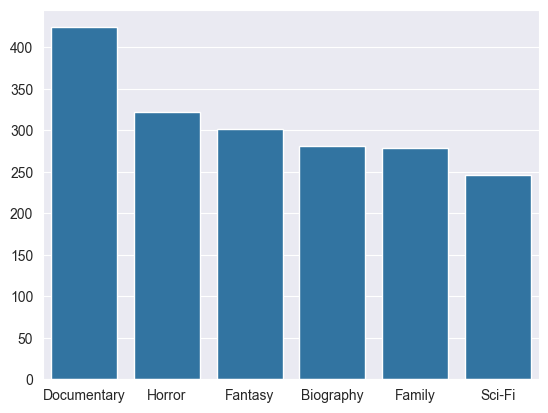

In [8]:
sns.barplot(y_train.sum())

<Axes: >

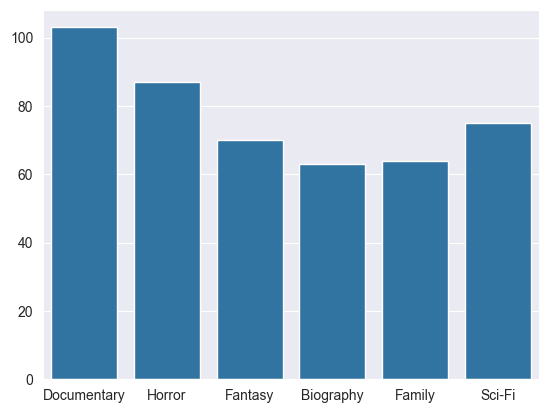

In [9]:
sns.barplot(y_val.sum())


# CNN Setup

In [58]:
def get_resnet_model(p_genres_to_predict):
    # Define the number of output classes
    num_classes = len(p_genres_to_predict)
    # Load the pre-trained VGG16 model
    #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False
    # Create a new model for genre prediction
    model.summary()
    return Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5, noise_shape=None, seed=None),
        Dense(num_classes, activation='sigmoid')  # Use sigmoid for multi-output regression
    ])

def get_custom_model(p_genres_to_predict):
    model = Sequential([
        Conv2D
    ])

def train_model(p_model, num_epochs, p_model_filename):
    p_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # Define callbacks
    checkpoint = ModelCheckpoint(p_model_filename,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 monitor='val_loss',
                                 mode='min',
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    # Train the model
    history = p_model.fit(
        x_train,
        y_train,
        epochs=num_epochs,  # Adjust the number of epochs as needed
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, early_stopping]
    )
    return history

# Actual Training

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24090886 (91.90 MB)
Trainable params: 526086 (2.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


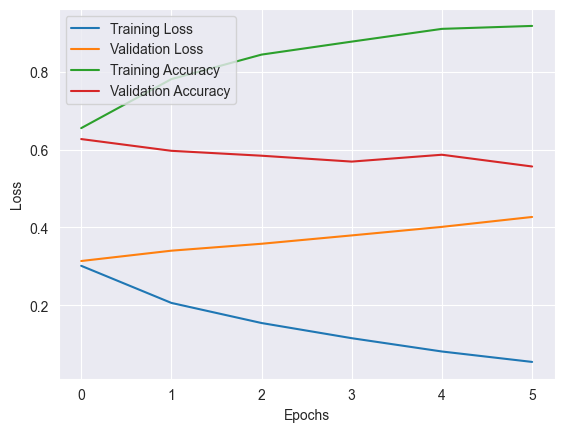

In [59]:
# Train the Resnet Model
model_filename = 'movie_genre_model.keras'
model = get_resnet_model(genres_to_predict)
history = train_model(model, 10, model_filename)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('movie_genre_model.keras')

# Result Evaluation

In [54]:
# Generate predictions
model.load_weights('movie_genre_model.keras') # initialize the best trained weights

model_preds = model.predict(x_test)
model_pred_classes = np.argmax(model_preds, axis=1)
#
#accuracy = accuracy_score(true_labels, model_pred_classes)
#print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(accuracy * 100))

16/16 [==============================] - 14s 804ms/step


(497, 6)
(497, 6)


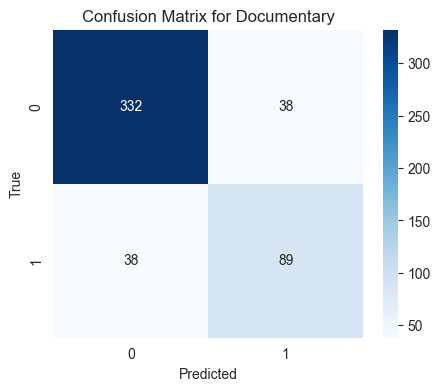

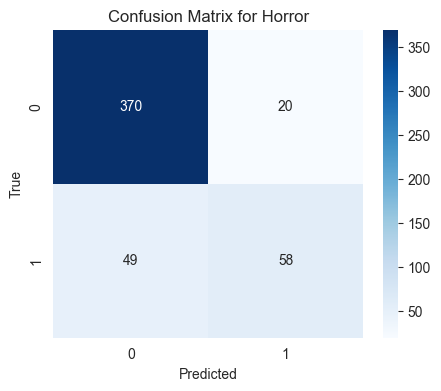

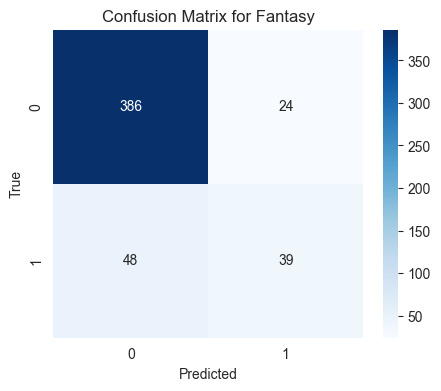

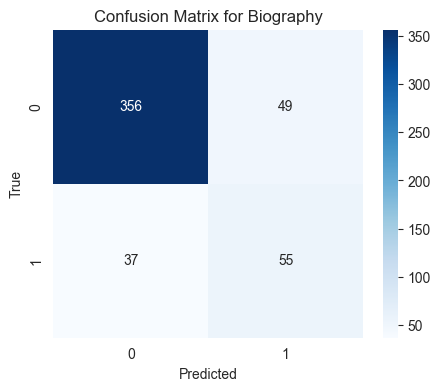

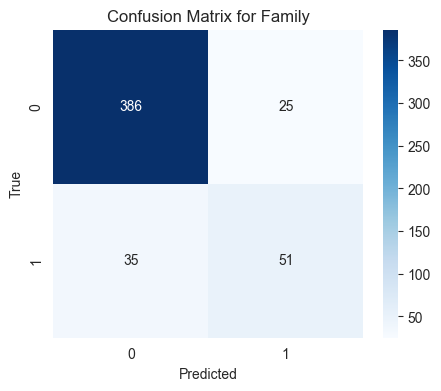

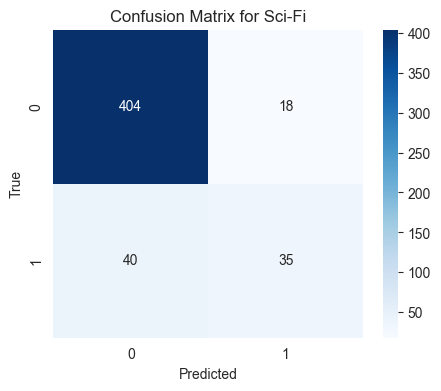

In [55]:
# generate a binary matrix of the actual ground truth values
#true_labels = y_test
#true_labels_binary = []
#for row in y_test:
#    binary_row = []
#    for genre in genres_to_predict:
#        binary_value = 0
#        if genre in row:
#            binary_value = 1
#        binary_row.append(binary_value)
#    true_labels_binary.append(binary_row)

# Binarize the prediction matrix
threshold = 0.4
pred_labels_binary = (model_preds > threshold).astype(int)

print(np.shape(y_test))
print(np.shape(pred_labels_binary))

# heatmap
cms = multilabel_confusion_matrix(y_test, pred_labels_binary)

# Plot each confusion matrix as a heatmap
for i, cm in enumerate(cms):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'Confusion Matrix for {genres_to_predict[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [56]:
cr = classification_report(
    y_test,
    pred_labels_binary,
    zero_division=0,
    target_names=genres_to_predict
)
print(cr)

              precision    recall  f1-score   support

 Documentary       0.70      0.70      0.70       127
      Horror       0.74      0.54      0.63       107
     Fantasy       0.62      0.45      0.52        87
   Biography       0.53      0.60      0.56        92
      Family       0.67      0.59      0.63        86
      Sci-Fi       0.66      0.47      0.55        75

   micro avg       0.65      0.57      0.61       574
   macro avg       0.65      0.56      0.60       574
weighted avg       0.66      0.57      0.61       574
 samples avg       0.54      0.58      0.54       574

